In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
repository = '/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD/'
data_directory = 'capstone_jd_msom_data-minus-click-data/'
%cd {repository} 
%ls -a

/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD
 capstone_jd_msom_data-minus-click-data/
'Clustering with K-prototype .ipynb'
 final_results_woCapacity.json
 .git/
 initial_data_cleaning_order.ipynb
 Inventory_optimization.ipynb
 .ipynb_checkpoints/
'OLS models - Lei.ipynb'
 order_after_engineer.csv
 order_aggregation_Lei.ipynb
 order_dict.json
 PyTorch_models_Ben.ipynb
 PyTorch_models_Ben_v2.ipynb
 PyTorch_models_Lei.ipynb
 PyTorch_pipe_Lei.ipynb
 README.md
'Shipping - Lei.ipynb'
'sklearn model - Lei revise on Shuyi.ipynb'
 sku_clustering.csv
 sku_with_cluster.csv
 warehouse_capacity_preprocessing.ipynb


In [5]:
%cd {repository + data_directory}
# 'skus' table
# skus = pd.read_csv('JD_sku_data.csv')
# 'users' table
# users = pd.read_csv('JD_user_data.csv')
# 'clicks' table
# clicks = pd.read_csv('JD_click_data.csv')
# 'orders' table
orders = pd.read_csv('JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('JD_network_data.csv')

/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD/capstone_jd_msom_data-minus-click-data


In [6]:
total_dc = network['dc_ID'].nunique()
total_dc_2 = orders['dc_ori'].nunique()
total_dc_3 = orders['dc_des'].nunique()
# central_dc = network['region_ID']
print(total_dc)
print(total_dc_2)
print(total_dc_3)

56
56
60


In [7]:
dc = 1

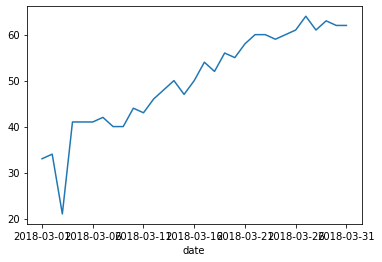

In [8]:
# Daily inventory (#SKU) in distribution center $dc
# Assume 1 unit per available inventory

inventory_dc = inventory.loc[inventory['dc_ID'] == dc]
inventory_dc_day = inventory_dc.groupby('date').size()
inventory_dc_day.plot()

In [9]:
# inventory_count_per_dc_day = inventory.groupby(['dc_ID', 'date']).filter(lambda x: x['dc_ID'] == 1).count()

In [10]:
shipping_master = pd.merge(delivery, orders, how='inner', on='order_ID')
# len(shipping_master.index)

# FYI: orders table has multiple rows with same order ID (product + gift items in one order)
# orders[orders['order_ID'] == 'e22627af66']

# FYI: a lot of data points have dc_org = dc_des
# Issue: ship_out_time does not equal to arr_station_time even when dc_ori = dc_des

# Preprocessing

# Filter out April data
shipping_master = shipping_master[pd.to_datetime(shipping_master['ship_out_time']).dt.month == 3]
shipping_master = shipping_master[pd.to_datetime(shipping_master['arr_station_time']).dt.month == 3]

# Convert time to date
shipping_master['ship_out_day'] = pd.to_datetime(shipping_master['ship_out_time']).dt.day
shipping_master['arr_day'] = pd.to_datetime(shipping_master['arr_station_time']).dt.day

shipping_master.head()

,package_ID,order_ID,type_x,ship_out_time,arr_station_time,arr_time,user_ID,sku_ID,order_date,order_time,...,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,ship_out_day,arr_day
0,dc3d6d2258,dc3d6d2258,1,2018-03-01 08:00:00,2018-03-01 15:00:00,2018-03-01 18:00:00,ee666e25c3,2e06817802,2018-03-01,2018-03-01 06:21:07.0,...,33.000000,0.0,0.0,0.0,3.000000,0,4,4,1,1
1,19802a570c,19802a570c,1,2018-03-01 10:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00,845df5b5f2,5ae1bb1c76,2018-03-01,2018-03-01 09:10:09.0,...,59.000000,19.0,0.0,0.0,0.000000,0,2,2,1,1
2,e22627af66,e22627af66,1,2018-03-01 11:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00,cae0d8c01f,b8c182c74f,2018-03-01,2018-03-01 10:50:41.0,...,188.000000,0.0,0.0,0.0,42.000000,0,5,5,1,1
3,e22627af66,e22627af66,1,2018-03-01 11:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00,cae0d8c01f,c98d32ff09,2018-03-01,2018-03-01 10:50:41.0,...,0.000000,0.0,0.0,0.0,0.000000,1,5,5,1,1
4,e22627af66,e22627af66,1,2018-03-01 11:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00,cae0d8c01f,c98d32ff09,2018-03-01,2018-03-01 10:50:41.0,...,-0.333333,0.0,0.0,0.0,0.333333,1,5,5,1,1


<Figure size 432x288 with 0 Axes>

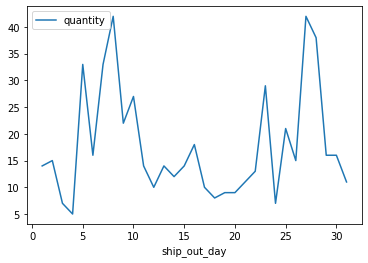

In [11]:
# Select only useful columns for ship-out: dc_ori, ship_out_day, total_quantity
ship_out = shipping_master[['dc_ori', 'ship_out_day', 'quantity']]
# Aggregate by sum of quantities. reset_index is important because GroupBy object has hierarchical index
ship_out = ship_out.groupby(['dc_ori', 'ship_out_day'])['quantity'].sum().reset_index()

ship_out_dc = ship_out.loc[ship_out['dc_ori'] == dc]
plt.figure()
ship_out_dc.plot(x = 'ship_out_day', y = 'quantity')

<Figure size 432x288 with 0 Axes>

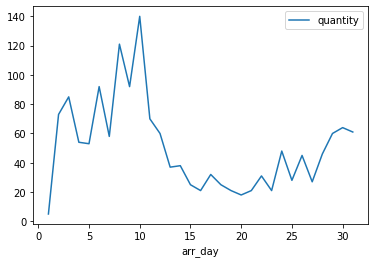

In [12]:
# Select only useful columns for arrival: dc_des, arr_day, total_quantity
arrival = shipping_master[['dc_des', 'arr_day', 'quantity']]
# Aggregate by sum of quantities. reset_index is important because GroupBy object has hierarchical index
arrival = arrival.groupby(['dc_des', 'arr_day'])['quantity'].sum().reset_index()

arrival_dc = arrival.loc[arrival['dc_des'] == dc]
plt.figure()
arrival_dc.plot(x = 'arr_day', y = 'quantity')

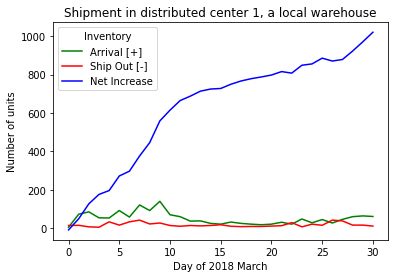

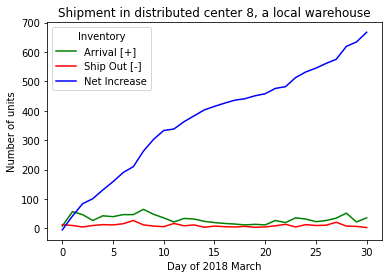

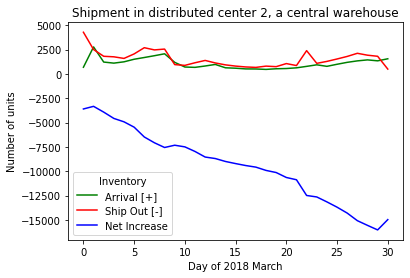

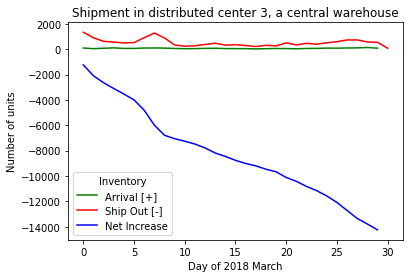

In [13]:
# Calculate accumulated inventory changes for given dc

def visualize_inventory(dc):
  plt.figure()

  inventory_dc = inventory.loc[inventory['dc_ID'] == dc]
  inventory_dc_day = inventory_dc.groupby('date').size()
  # print('Initial inventory: ' + str(0 if inventory_dc_day.empty else int(inventory_dc_day['2018-03-01'])))
  # inventory_dc_day.plot()

  arrival_dc = arrival.loc[arrival['dc_des'] == dc]
  plt.plot(arrival_dc['quantity'].reset_index(drop=True), label='Arrival [+]', color='green')
  # arrival_dc.plot(x = 'arr_day', y = 'quantity')

  ship_out_dc = ship_out.loc[ship_out['dc_ori'] == dc]
  plt.plot(ship_out_dc['quantity'].reset_index(drop=True), label='Ship Out [-]', color='red')
  # ship_out_dc.plot(x = 'ship_out_day', y = 'quantity')

  plt.plot(arrival_dc['quantity'].reset_index(drop=True).cumsum() - ship_out_dc['quantity'].reset_index(drop=True).cumsum(), label='Net Increase', color='blue')

  plt.legend(title='Inventory')
  plt.ylabel('Number of units')
  plt.xlabel('Day of 2018 March')
  plt.title('Shipment in distributed center ' + str(dc) + str(', a central warehouse' if dc in network['region_ID'].values else ', a local warehouse'))
  plt.show()

  # Issue: when one Series is empty, Net Increase is all NaN and does not display

visualize_inventory(1)
visualize_inventory(8)
visualize_inventory(2)
visualize_inventory(3)

In [16]:
# Calculate accumulated inventory changes

max_capacity_dict = dict()

# for dc in network['dc_ID']:
for dc in orders['dc_des'].unique():
  dc = int(dc)
  capacity_dc_cum = np.zeros(32)

  # Initial Inventory
  inventory_dc = inventory.loc[inventory['dc_ID'] == dc]
  inventory_dc_day = inventory_dc.groupby('date').size()
  capacity_dc_cum[0] = 0 if inventory_dc_day.empty else int(inventory_dc_day['2018-03-01'])
  # print(capacity_dc_cum[0])

  # Accumulated inventory decrease and increase
  ship_out_dc = ship_out.loc[ship_out['dc_ori'] == dc]
  ship_out_dc_cum = ship_out_dc.set_index(['dc_ori', 'ship_out_day']).cumsum().reset_index()
  arrival_dc = arrival.loc[arrival['dc_des'] == dc]
  arrival_dc_cum = arrival_dc.set_index(['dc_des', 'arr_day']).cumsum().reset_index()

  for i in range(1, 32):
    arrival_tmp = arrival_dc_cum.loc[arrival_dc_cum['arr_day'] == i]['quantity']
    arrival_cnt = 0 if arrival_tmp.empty else int(arrival_tmp)
    # print(arrival_cnt)
    ship_out_tmp = ship_out_dc_cum.loc[ship_out_dc_cum['ship_out_day'] == i]['quantity']
    ship_out_cnt = 0 if ship_out_tmp.empty else int(ship_out_tmp)
    # print(ship_out_cnt)
    capacity_dc_cum[i] = capacity_dc_cum[0] + arrival_cnt - ship_out_cnt
    # print('day ' + str(i) + ': ' + str(capacity_dc_cum[i]))
  
  # Store info about dc_ID, maximum capacity (the difference between max inventory point and min inventory point), and if the dc is a central warehouse
  max_capacity_dict[dc] = [dc, capacity_dc_cum.max() - capacity_dc_cum.min(), dc in network['region_ID'].values]

max_capacity_df = pd.DataFrame.from_dict(max_capacity_dict, orient='index', columns=['dc_ID', 'max_capacity', 'is_central_dc']).sort_values(by='dc_ID').reset_index(drop=True)
max_capacity_df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#   display(max_capacity_df)  


,dc_ID,max_capacity,is_central_dc
0,1,1030.0,False
1,2,16037.0,True
2,3,14326.0,True
3,4,8593.0,True
4,5,21558.0,True
5,6,5177.0,False
6,7,14975.0,True
7,8,672.0,False
8,9,23580.0,True
9,10,6057.0,True


In [17]:
import json
with open('warehouse_capacity.json','w') as f:
   json.dump(max_capacity_dict, f)